# SwyftModule

In this notebook, we will go through the basic steps of performing parameter inference with Swyft.

## Setup

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import swyft
import pylab as plt
import scipy.stats

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [4]:
N = 10000  # Number of samples
z = np.random.rand(N, 1)*2-1  # Uniform prior over [-1, 1]
x = z + np.random.randn(N, 1)*0.1

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [5]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.LogRatioEstimator_1dim`, for mapping $x$ and $z$ onto a ratio estimator object.

In [6]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).  Since our training data is double precision in this example, we have to set `precision = 64`.

In [11]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', devices = 1, max_epochs = 10, precision = 64)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data. We preserve 1000 samples for validation and testing.  The setting of `num_workers` will depend on your system.

In [12]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.02, 0.1], num_workers = 3, batch_size = 128)

In [13]:
network = Network()

Finally, we perform the fit. (Potential warning messages related to logging and checkpoints can be ignored at this point.  Proper logging will be discussed in a later notebook.)

In [14]:
trainer.fit(network, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
-----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.139     Total estimated model params size (MB)


Epoch 0:  97%|█████████▋| 68/70 [00:01<00:00, 67.84it/s, loss=-0.787, v_num=1e+7] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 68/70 [00:01<00:00, 63.49it/s, loss=-0.805, v_num=1e+7, val_loss=-.801]
Validation: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 68/70 [00:01<00:00, 66.51it/s, loss=-0.817, v_num=1e+7, val_loss=-.778]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 68/70 [00:01<00:00, 58.75it/s, loss=-0.79, v_num=1e+7, val_loss=-.774] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 68/70 [00:01<00:00, 59.72it/s, loss=-0.821, v_num=1e+7, val_loss=-.802]
Validation: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 68/70 [00:01<00:00, 64.89it/s, loss=-0.803, v_num=1e+7, val_loss=-.801]
Validation: 0it [00:00, ?it/s]
Epoch 6:  97%|█████████▋| 68/70 [00:01<00:00, 63.47it/s, loss=-0.798, v_num=1e+7, val_loss=-.796]
Validation: 0it [00:00, ?it/s]
Epoch 7:  97%|█████████▋| 68/70 [00:01<00:00, 66.13it/s, loss=-0.822, v_num=1e+7, val_loss=-.787]
Validation: 0i

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 49.40it/s, loss=-0.818, v_num=1e+7, val_loss=-.795]


Finally, we can test the network performance on the separate testing samples.

In [16]:
trainer.test(network, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 202.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.8428825986368504    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.8428825986368504}]

## Inference

We assume that we measure the values $x=0.2$.

In [17]:
x0 = 0.2

Below we will need that this is a `Sample` object.

In [18]:
A = swyft.Sample(x = np.array([x0]))

We first generate a large number of prior samples.

In [19]:
B = swyft.Samples(z = np.random.rand(1_000_000, 1)*2-1)

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [21]:
predictions = trainer.infer(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 977/977 [00:07<00:00, 129.65it/s]


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

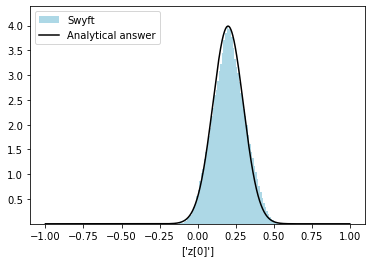

In [23]:
# Plot swyft results
plt.hist(predictions.params[:,0].numpy(), weights = predictions.weights.numpy(),
         bins = 200, density = True, color = 'lightblue', label = "Swyft");
plt.xlabel(predictions.parnames[0])

# Compare with analytical result
xn = np.linspace(-1, 1, 1000)
yn = scipy.stats.norm.pdf(xn, x0, 0.1)
plt.plot(xn, yn, 'k', label = "Analytical answer")
plt.ylim([1e-6, yn.max()*1.1])
#plt.yscale('log')
plt.legend(loc=2)